# KAIST AI605 Assignment 5: Language Modelling

## Rubric

### Deadline
The deadline for this assignment is: Friday 2nd December 2022 (Week 14) 11:59pm

### Submission
Please submit your assignment via [KLMS](https://klms.kaist.ac.kr). You must submit both (1) a PDF of your solutions and (2) the Jupyter Notebook file (.ipynb).

Use in-line LaTeX for mathematical expressions.

### Collaboration
This assignment is not a group assignment so make sure your answer and code are your own.

### Grading
The total number of marks avaiable is 30 points.

### Environment
This assignment will mostly use the transformers library from huggingface.

The use of a GPU will be beneficial for this assignment.

If you do not have a GPU on your laptop, it is acceptable to use [Google Colab (free)](https://colab.research.google.com) or the departmental subscription of [VESSL](https://vessl.ai),
**please contact me ASAP to be added if you are from a different department**.


The required environment for this is Python 3.9. Run the following cell to set up the environment.

In [ ]:
# !pip install numpy torch tqdm transformers matplotlib

# Problem 0 - Load The Data
The data for Problems 1, 2 and 3 can be downloaded from KLMS. Each line in the file is an instance is a JSON dictioanary of a Wikipedia. For this assignment only the **text** field is required.

* Reserve 10% of the pages for validation data
* Use any other portion of the data for training

`{"title": "the title of the Wikipedia page",  "text":"the text in the Wikipedia page"}`

In [ ]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import torch
from torch import nn
import json
from nltk import word_tokenize
from collections import defaultdict, Counter
import torch.nn.functional as F
import numpy as np
import math
from datasets import *
from transformers import *
from tokenizers import *
import os
from tqdm import tqdm
import nltk

/usr/local/lib/python3.8/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [ ]:
!ls 'drive/MyDrive/nlp'

dev.json	snli_1.0_dev.jsonl   snli_1.0_train.jsonl  train.json
model_small.pt	snli_1.0_test.jsonl  test.json		   wiki.jsonl


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def load_instances(filename):
    with open(filename) as f:
        for line in f:
            inst = json.loads(line)
            text = inst['text']
            yield word_tokenize(text)
all_inst = list(load_instances("drive/MyDrive/nlp/wiki.jsonl"))
# print(all_inst[0])
n = len(all_inst)
print(f'All data: {n}')
train_instances, dev_instances = all_inst[:int(n*0.9)], all_inst[int(n*0.9):]
print(f'Train lenght: {len(train_instances)}')
print(f'Test lenght: {len(dev_instances)}')

# Problem 1 - Features of Language (6 points)

## Problem 1.1 (4 points) - Zipfs Law

Zipfs law (introduced in Lecture 1) indicates a reverse exponential relationship between the frequency of a token $w$, $f_w$, and its rank of frequency $r_w$ (where rank is the position with respect to frequency in comparison to other words).

$$
f_w \approx \frac{k}{r_w^\alpha}
$$


* Find the frequencies of all unique tokens in the dataset and rank them

* Plot the frequency vs rank graph for the highest 10,000 ranked tokens with a log-log scale

* Plot a line of best fit and estimate the values of $k$ and $\alpha$


In [ ]:
vocab_counter = Counter()
for text in all_inst:
    vocab_counter.update(text)
vocab_counter = dict(sorted(vocab_counter.items(), key=lambda item: item[1], reverse = True))
vocab_counter = {i + 1: (token, frequency) for i, (token, frequency) in enumerate(vocab_counter.items())}
# most_common = {math.log(i): math.log(items[1]) for i, items in vocab_counter.items() if items[1]>=10000}
most_common = {i: items[1] for j, (i, items) in enumerate(vocab_counter.items()) if j>=10000}
vocab_counter

{1: ('the', 869431),
 2: (',', 858193),
 3: ('.', 574493),
 4: ('of', 477376),
 5: ('and', 423298),
 6: ('in', 319390),
 7: ('to', 307820),
 8: ('a', 264721),
 9: ('was', 154621),
 10: ('The', 131163),
 11: ("'s", 115968),
 12: ('that', 114943),
 13: ('as', 114408),
 14: (')', 113762),
 15: ('(', 113746),
 16: ('for', 102230),
 17: ('``', 99072),
 18: ('by', 97725),
 19: ('with', 96947),
 20: ('on', 95504),
 21: ('is', 94711),
 22: ("''", 93799),
 23: ('from', 74246),
 24: ('his', 67246),
 25: ('were', 61886),
 26: ('at', 60693),
 27: ('it', 54504),
 28: ('which', 49433),
 29: ('had', 49041),
 30: ('an', 48956),
 31: ('are', 48228),
 32: ('he', 45792),
 33: (';', 43640),
 34: ('be', 41782),
 35: ('In', 40613),
 36: (':', 38625),
 37: ('have', 38461),
 38: ('or', 35965),
 39: ('not', 35631),
 40: ('but', 34690),
 41: ('been', 33255),
 42: ('its', 32761),
 43: ('their', 32222),
 44: ('her', 28214),
 45: ('also', 27907),
 46: ('has', 27283),
 47: ('this', 25112),
 48: ('first', 24762),
 4

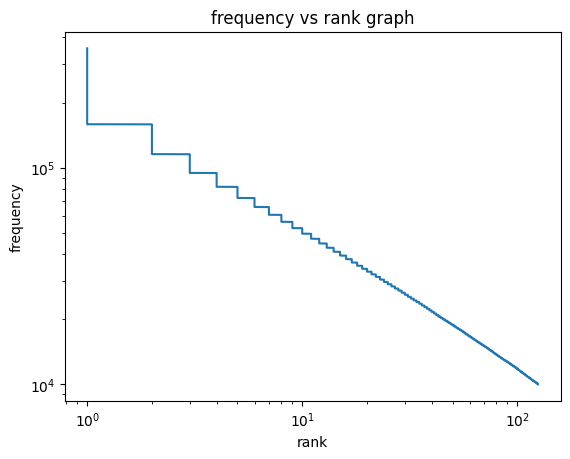

In [ ]:
import matplotlib.pyplot as plt
plt.plot(most_common.values(),most_common.keys())
plt.ylabel('frequency')
plt.xlabel('rank')
plt.title("frequency vs rank graph")
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
# normalized frequency
alpha = 0.1
k = 3.65
y = k / (np.array([*most_common.values()])**alpha)

In [ ]:
#find line of best fit
x = np.array([*most_common.values()])
y = np.array([*most_common.keys()])
a, b, c = np.polyfit(1/y, x, 2)

In [ ]:
y_pred = a*x**2 + b*x + c
y_pred

array([1.62038332e+10, 1.62038332e+10, 1.62038332e+10, ...,
       1.03707837e+06, 1.03707837e+06, 1.03707837e+06])

In [ ]:
from scipy.optimize import curve_fit

def f(x, A, B):
    return A/(x**B)

popt, pcov = curve_fit(f, x, y)

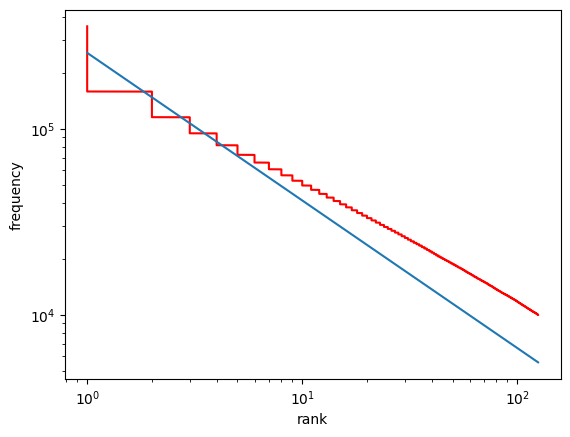

In [ ]:
plt.plot(x,y, color = 'red')
plt.plot(x, f(x, *popt))
plt.ylabel('frequency')
plt.xlabel('rank')
plt.xscale('log')
plt.yscale('log')
plt.show()

## Problem 1.2 (2 points) - Contextual Embeddings

[Deep contextualized word representations (Peters et al., 2018)](https://arxiv.org/pdf/1802.05365.pdf) uses an LSTM-based architecture to generate meaning representations of tokens.

Using the linked paper as reference, highlight the differences between using static word embeddings and contextual representations and suggest two reasons how the language-modelling objective helps other NLP tasks.

Static word emmbeddings are using finite large number of vocab words to emmbed the meaning of each token.

The LSTM-based architecture (to be exact the one intrduce in paper biLM is trying to capture deeper sense of the word (like part of speech). It's using the subwords units and character convolutions. The model is learning the linear combination of the vectors stacked above each input word for each end task.

As mentioned in the article previous approaches allowed a single context independent representation for each word.

# Problem 2 - BERT-style Language Models (14 points)

## Problem 2.1 (8 points) - BERT Language Model
Using the provided data, train a language model with the [BERT]((https://aclanthology.org/N19-1423.pdf) masked language model objective (NSP prediction task is not reuqired). Select appropriate model size and hyperparameters.

* Make the training data yourself

* Print a sample of training instances (both the model inputs and expected outputs)

* Plot the loss regularly (e.g. after an epoch or fixed number of training steps) on a graph. Report the loss for both the training data and validation data.

* Use the `transformers` library implementation of a suitable tokenizer and model for language modelling with BERT. But do not use a pre-trained language model (i.e. start with a randomly initialized model).  

Hint: you can use [BERTConfig](https://huggingface.co/docs/transformers/v4.24.0/en/model_doc/bert#transformers.BertConfig) to configure your language model, and use [BERTForMaskedLM](https://huggingface.co/docs/transformers/v4.24.0/en/model_doc/bert#transformers.BertForMaskedLM) which is a pre-configured language model.

Hint: You should use the [AdamW optimizer](https://huggingface.co/docs/transformers/v4.24.0/en/main_classes/optimizer_schedules#transformers.AdamW)

Code for this task was inspired by many different tutorials about transformers, I don't know how without using some tutorials and documenattion were we supposed to finish this task.

In [ ]:
from transformers import AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_ac

In [ ]:

files = ["drive/MyDrive/nlp/wiki.jsonl"]
model_path = "drive/MyDrive/nlp/pretrained-bert"

# 30,522 vocab is BERT's default vocab size
vocab_size = 30_522
# maximum sequence length, lowering will result to faster training (when increasing batch size)
max_length = 512
# whether to truncate
truncate_longer_samples = True

In [ ]:
dataset = load_dataset('json', data_files=files, split="train")

In [ ]:
dataset['text'][0]

'7 World Trade Center (7 WTC, WTC-7, or Tower 7) refers to two buildings that have existed at the same location within the World Trade Center site in Lower Manhattan, New York City. The original structure, part of the original World Trade Center, was completed in 1987 and was destroyed in the September 11 attacks in 2001. The current structure opened in May 2006. Both buildings were developed by Larry Silverstein, who holds a ground lease for the site from the Port Authority of New York and New Jersey.\nThe original 7 World Trade Center was 47 stories tall, clad in red granite masonry, and occupied a trapezoidal footprint. An elevated walkway spanning Vesey Street connected the building to the World Trade Center plaza. The building was situated above a Consolidated Edison power substation, which imposed unique structural design constraints. When the building opened in 1987, Silverstein had difficulties attracting tenants. Salomon Brothers signed a long-term lease in 1988 and became the

In [ ]:
# split the dataset into training (90%) and testing (10%)
d = dataset.train_test_split(test_size=0.1)
d["train"], d["test"]

(Dataset({
     features: ['title', 'text'],
     num_rows: 2622
 }), Dataset({
     features: ['title', 'text'],
     num_rows: 292
 }))

In [ ]:
# from https://www.thepythoncode.com/article/pretraining-bert-huggingface-transformers-in-python
def encode_with_truncation(examples):
    """Mapping function to tokenize the sentences passed with truncation"""
    return bert_tokenizer(examples["text"], truncation=True, padding="max_length",
                   max_length=max_length, return_special_tokens_mask=True)

def encode_without_truncation(examples):
    """Mapping function to tokenize the sentences passed without truncation"""
    return bert_tokenizer(examples["text"], return_special_tokens_mask=True)


In [ ]:

# the encode function will depend on the truncate_longer_samples variable
encode = encode_with_truncation if truncate_longer_samples else encode_without_truncation
# tokenizing the train dataset
train_dataset = d["train"].map(encode, batched=True)
# tokenizing the testing dataset
test_dataset = d["test"].map(encode, batched=True)
if truncate_longer_samples:
    # remove other columns and set input_ids and attention_mask as PyTorch tensors
    train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
    test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
else:
    # remove other columns, and remain them as Python lists
    test_dataset.set_format(columns=["input_ids", "attention_mask", "special_tokens_mask"])
    train_dataset.set_format(columns=["input_ids", "attention_mask", "special_tokens_mask"])

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
from itertools import chain
# from: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
def group_texts(examples):
    # concatenate all texts
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])

    if total_length >= max_length:
        total_length = (total_length // max_length) * max_length
    # spliting by max_length
    result = {
        k: [t[i : i + max_length] for i in range(0, total_length, max_length)]
        for k, t in concatenated_examples.items()
    }
    return result

# https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map
if not truncate_longer_samples:
  #for train dataset and test separately
    train_dataset = train_dataset.map(group_texts, batched=True,
                                    desc=f"Grouping texts in chunks of {max_length}")
    test_dataset = test_dataset.map(group_texts, batched=True,
                                  desc=f"Grouping texts in chunks of {max_length}")
    # converting them from lists to torch tensors
    train_dataset.set_format("torch")
    test_dataset.set_format("torch")

In [ ]:
len(train_dataset), len(test_dataset)

(2622, 292)

In [ ]:
# initialize the model with the config
model_config = BertConfig(vocab_size=vocab_size, max_position_embeddings=max_length)
model = BertForMaskedLM(config=model_config)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)

In [ ]:
# initialize the data collator, randomly masking 20% (default is 15%) of the tokens for the Masked Language
# Modeling (MLM) task
data_collator = DataCollatorForLanguageModeling(
    tokenizer=bert_tokenizer, mlm=True, mlm_probability=0.2
)

In [ ]:
training_args = TrainingArguments(
    output_dir=model_path,          # output directory to where save model checkpoint
    evaluation_strategy="steps",    # evaluate each `logging_steps` steps
    overwrite_output_dir=True,
    num_train_epochs=10,            # number of training epochs, feel free to tweak
    per_device_train_batch_size=4, # the training batch size, put it as high as your GPU memory fits
    gradient_accumulation_steps=8,  # accumulating the gradients before updating the weights
    per_device_eval_batch_size=32,  # evaluation batch size
    logging_steps=100,             # evaluate, log and save model checkpoints every 1000 step
    save_steps=1000,
    # load_best_model_at_end=True,  # whether to load the best model (in terms of loss) at the end of training
    save_total_limit=3,           # space limitation you let only x model weights saved in the disk
)

using `logging_steps` to initialize `eval_steps` to 100
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
# initialize the trainer and pass everything to it
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [ ]:
# train the model
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 2622
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 8
  Total optimization steps = 820
  Number of trainable parameters = 109514298


Step,Training Loss,Validation Loss
100,7.168100,7.033569
200,6.959800,6.902548
300,6.875200,6.865242
400,6.829200,6.795207
500,6.769000,6.754650
600,6.735000,6.708695
700,6.713400,6.745007
800,6.702900,6.681800


The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 292
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 292
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
**

TrainOutput(global_step=820, training_loss=6.840327788562309, metrics={'train_runtime': 3051.428, 'train_samples_per_second': 8.593, 'train_steps_per_second': 0.269, 'total_flos': 6901230191616000.0, 'train_loss': 6.840327788562309, 'epoch': 10.0})

In [ ]:
import json

# Opening JSON file
f = open("drive/MyDrive/nlp/pretrained-bert/trained_model/trainer_state.json")
train_loss = []
# returns JSON object as
# a dictionary
data = json.load(f)
for i in data['log_history']:
  try:
    print(i['eval_loss'])
    train_loss.append(i['eval_loss'])
  except:
    pass
# Closing file
f.close()


6.645091533660889
6.5709075927734375
6.557473659515381
6.5397114753723145


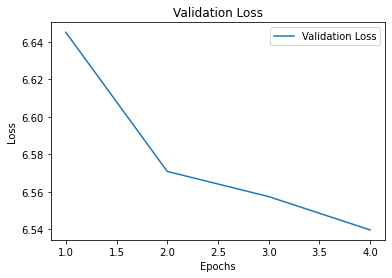

In [ ]:
from matplotlib.pylab import plt
from numpy import arange

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1,len(train_loss)+1)

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display the plot
plt.legend(loc='best')
plt.show()

In [ ]:
import torch
torch.save(model, '/model')

saved_model = torch.load('/model')

In [ ]:
# load the model checkpoint
model = BertForMaskedLM.from_pretrained(os.path.join("pretrained-bert/checkpoint-4000")) #model_path,

loading configuration file pretrained-bert/checkpoint-4000/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pretrained-bert/checkpoint-4000/pytorch_model.bin
All model checkpoint weights were used when initializing BertForMaskedLM.

All the weights of BertForMaskedLM were initialized from the model checkpoint at pretrained-bert/checkpoint-4000.
If your task is similar to the task the model of the ch

In [ ]:
fill_mask = pipeline("fill-mask", model=model, tokenizer=bert_tokenizer) # form documatation and tutorials from Hugging Face

In [ ]:
# perform predictions
# examples taken from internet
examples = [
  "Today's most trending hashtags on [MASK] is Donald Trump",
  "The [MASK] was cloudy yesterday, but today it's rainy.",
  "The capital of France is [MASK]."
]
for example in examples:
  for prediction in fill_mask(example):
    print(f"{prediction['sequence']}, confidence: {prediction['score']}")
  print("="*50)

today's most trending hashtags on s is donald trump, confidence: 0.08419137448072433
today's most trending hashtags on'is donald trump, confidence: 0.052732113748788834
today's most trending hashtags on, is donald trump, confidence: 0.04283653199672699
today's most trending hashtags on the is donald trump, confidence: 0.03841094672679901
today's most trending hashtags on. is donald trump, confidence: 0.036555215716362
the the was cloudy yesterday, but today it's rainy., confidence: 0.05472173914313316
the'was cloudy yesterday, but today it's rainy., confidence: 0.04944892227649689
the s was cloudy yesterday, but today it's rainy., confidence: 0.04753046855330467
the. was cloudy yesterday, but today it's rainy., confidence: 0.040619831532239914
the, was cloudy yesterday, but today it's rainy., confidence: 0.03043619729578495


## Problem 2.2 (2 points) - Hyperparameters
Experiment with changing model 3-4 of the model hyperparameters (e.g. sequence length, number of attention heads, hidden dimension, number of layers, etc). How do these change the training behaviour and loss of your model and why?

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

files = ["drive/MyDrive/nlp/wiki.jsonl"]
model_path = "drive/MyDrive/nlp/pretrained-bert"

# 30,522 vocab is BERT's default vocab size, feel free to tweak
vocab_size = 30_522
# maximum sequence length, lowering will result to faster training (when increasing batch size)
max_length = 206
# whether to truncate
truncate_longer_samples = True

# the encode function will depend on the truncate_longer_samples variable
encode = encode_with_truncation if truncate_longer_samples else encode_without_truncation
# tokenizing the train dataset
train_dataset = d["train"].map(encode, batched=True)
# tokenizing the testing dataset
test_dataset = d["test"].map(encode, batched=True)
if truncate_longer_samples:
    # remove other columns and set input_ids and attention_mask as PyTorch tensors
    train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
    test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
else:
    # remove other columns, and remain them as Python lists
    test_dataset.set_format(columns=["input_ids", "attention_mask"])
    train_dataset.set_format(columns=["input_ids", "attention_mask"])

if not truncate_longer_samples:
    train_dataset = train_dataset.map(group_texts, batched=True,
                                    desc=f"Grouping texts in chunks of {max_length}")
    test_dataset = test_dataset.map(group_texts, batched=True,
                                  desc=f"Grouping texts in chunks of {max_length}")
    # convert them from lists to torch tensors
    train_dataset.set_format("torch")
    test_dataset.set_format("torch")

# initialize the model with the config
model_config = BertConfig(vocab_size=vocab_size, max_position_embeddings=max_length)
model = BertForMaskedLM(config=model_config)

# initialize the data collator, randomly masking 20% (default is 15%) of the tokens for the Masked Language
# Modeling (MLM) task
data_collator = DataCollatorForLanguageModeling(
    tokenizer=bert_tokenizer, mlm=True, mlm_probability=0.2
)

# initialize the trainer and pass everything to it
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# train the model
trainer.train()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file to

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 2622
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 8
  Total optimization steps = 820
  Number of trainable parameters = 109279290
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
100,8.086800,7.255520
200,7.115100,7.044553
300,6.946600,6.954809
400,6.898200,6.870529
500,6.833300,6.888351
600,6.795600,6.782452
700,6.755900,6.826094
800,6.743600,6.778284


The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 292
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 292
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
**

TrainOutput(global_step=820, training_loss=7.015343735857708, metrics={'train_runtime': 1247.3093, 'train_samples_per_second': 21.021, 'train_steps_per_second': 0.657, 'total_flos': 2776666834908000.0, 'train_loss': 7.015343735857708, 'epoch': 10.0})

Shortening the sentence is making model learn less form each part and as a consequences the loss is dereasing slower but its increasing the speed of learning. Since the task is to find out the behaviour of the model after changing only one parameter I did not increase the batch size (it's a very common trick to preserve the loss).

In [ ]:
training_args = TrainingArguments(
    output_dir=model_path,          # output directory to where save model checkpoint
    evaluation_strategy="steps",    # evaluate each `logging_steps` steps
    overwrite_output_dir=True,
    num_train_epochs=1,            # number of training epochs, feel free to tweak
    per_device_train_batch_size=4, # the training batch size, put it as high as your GPU memory fits
    gradient_accumulation_steps=8,  # accumulating the gradients before updating the weights
    per_device_eval_batch_size=32,  # evaluation batch size
    logging_steps=50,             # evaluate, log and save model checkpoints every 1000 step
    # save_steps=1000,
    # load_best_model_at_end=True,  # whether to load the best model (in terms of loss) at the end of training
    # save_total_limit=3,           # whether you don't have much space so you let only 3 model weights saved in the disk
    report_to="wandb"              # for ploting loss curve
)

using `logging_steps` to initialize `eval_steps` to 50
PyTorch: setting up devices


In [ ]:
for num in [2,4,6]:
  bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
  model_path = "drive/MyDrive/nlp/pretrained-bert"

  # the encode function will depend on the truncate_longer_samples variable
  encode = encode_with_truncation if truncate_longer_samples else encode_without_truncation
  # tokenizing the train dataset
  train_dataset = d["train"].map(encode, batched=True)
  # tokenizing the testing dataset
  test_dataset = d["test"].map(encode, batched=True)
  if truncate_longer_samples:
      # remove other columns and set input_ids and attention_mask as PyTorch tensors
      train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
      test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
  else:
      # remove other columns, and remain them as Python lists
      test_dataset.set_format(columns=["input_ids", "attention_mask"])
      train_dataset.set_format(columns=["input_ids", "attention_mask"])

  if not truncate_longer_samples:
      train_dataset = train_dataset.map(group_texts, batched=True,
                                      desc=f"Grouping texts in chunks of {max_length}")
      test_dataset = test_dataset.map(group_texts, batched=True,
                                    desc=f"Grouping texts in chunks of {max_length}")
      # convert them from lists to torch tensors
      train_dataset.set_format("torch")
      test_dataset.set_format("torch")

  # initialize the model with the config
  model_config = BertConfig(vocab_size=vocab_size, max_position_embeddings=max_length,num_attention_heads = num)
  model = BertForMaskedLM(config=model_config)
  # masking data
  data_collator = DataCollatorForLanguageModeling(
      tokenizer=bert_tokenizer, mlm=True, mlm_probability=0.2
  )

  # initialize the trainer and pass everything to it
  trainer = Trainer(
      model=model,
      args=training_args,
      data_collator=data_collator,
      train_dataset=train_dataset,
      eval_dataset=test_dataset,
  )

  # train the model
  trainer.train()

# # post-training analysis, testing, other logged code
# wandb.finish()


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file to

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2622
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 8
  Total optimization steps = 82
  Number of trainable parameters = 109514298
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
ERROR:wandb.jupyte

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
50,8.724800,8.135065


The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 292
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_p

Step,Training Loss,Validation Loss
50,8.639500,8.056652


The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 292
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_p

Step,Training Loss,Validation Loss
50,8.640700,8.057430


The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 292
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_p

ValueError: ignored

Num of attention head | Validation loss
--- | ---
2 | 8.135065
4 | 8.056652
6 | 8.057430
12 | 7.033569

Increasing the num of attention head will increase the model accuracy and performence. Due to long trainig the experiments were performed only on one epoch.



hidden dimension:

In [ ]:
training_args = TrainingArguments(
    output_dir=model_path,          # output directory to where save model checkpoint
    evaluation_strategy="steps",    # evaluate each `logging_steps` steps
    overwrite_output_dir=True,
    num_train_epochs=2,            # number of training epochs, feel free to tweak
    per_device_train_batch_size=4, # the training batch size, put it as high as your GPU memory fits
    gradient_accumulation_steps=8,  # accumulating the gradients before updating the weights
    per_device_eval_batch_size=32,  # evaluation batch size
    logging_steps=50,             # evaluate, log and save model checkpoints every 1000 step
    # save_steps=1000,
    # load_best_model_at_end=True,  # whether to load the best model (in terms of loss) at the end of training
    # save_total_limit=3,           # whether you don't have much space so you let only 3 model weights saved in the disk
    report_to="wandb"              # for ploting loss curve
)

using `logging_steps` to initialize `eval_steps` to 50
PyTorch: setting up devices


In [ ]:
# bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# # 30,522 vocab is BERT's default vocab size, feel free to tweak
# vocab_size = 30_522
# # maximum sequence length, lowering will result to faster training (when increasing batch size)
# max_length = 512
# # whether to truncate
# truncate_longer_samples = True

# # the encode function will depend on the truncate_longer_samples variable
# encode = encode_with_truncation if truncate_longer_samples else encode_without_truncation
# # tokenizing the train dataset
# train_dataset = d["train"].map(encode, batched=True)
# # tokenizing the testing dataset
# test_dataset = d["test"].map(encode, batched=True)
# if truncate_longer_samples:
#     # remove other columns and set input_ids and attention_mask as PyTorch tensors
#     train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
#     test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
# else:
#     # remove other columns, and remain them as Python lists
#     test_dataset.set_format(columns=["input_ids", "attention_mask"])
#     train_dataset.set_format(columns=["input_ids", "attention_mask"])

# if not truncate_longer_samples:
#     train_dataset = train_dataset.map(group_texts, batched=True,
#                                     desc=f"Grouping texts in chunks of {max_length}")
#     test_dataset = test_dataset.map(group_texts, batched=True,
#                                   desc=f"Grouping texts in chunks of {max_length}")
#     # convert them from lists to torch tensors
#     train_dataset.set_format("torch")
#     test_dataset.set_format("torch")


In [ ]:
torch.cuda.empty_cache()

In [ ]:
for hid_size in [144,240,480]:
  # initialize the model with the config
  model_config = BertConfig(vocab_size=vocab_size, max_position_embeddings=max_length, hidden_size = hid_size)
  model = BertForMaskedLM(config=model_config)

  data_collator = DataCollatorForLanguageModeling(
      tokenizer=bert_tokenizer, mlm=True, mlm_probability=0.2
  )

  # initialize the trainer and pass everything to it
  trainer = Trainer(
      model=model,
      args=training_args,
      data_collator=data_collator,
      train_dataset=train_dataset,
      eval_dataset=test_dataset,
  )

  # train the model
  trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 2622
  Num Epochs = 2
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 8
  Total optimization steps = 164
  Number of trainable parameters = 16185738
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
50,9.982400,9.799538
100,9.690800,9.590857
150,9.539700,9.499054


The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 292
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 292
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
**

Step,Training Loss,Validation Loss
50,9.740000,9.439717
100,9.260200,9.095019
150,9.015500,8.949517


The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 292
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 292
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
**

Step,Training Loss,Validation Loss
50,9.149400,8.608430
100,8.298400,8.031805
150,7.899700,7.804163


The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 292
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 292
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: text, special_tokens_mask, title. If text, special_tokens_mask, title are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
**

Hidden dimension size | Validation loss (final) | Number of trainable parameters
--- | --- | ---
144 | 9.499054 |16185738
240 | 8.949517 |28060266
480 | 7.804163 |61697946

Hidden dimension size is clearly correlated to the size of a whole model so increasing this parameter will give us better performance of course it will also slow down trainig significantly.

## Problem 2.3 (4 points) - BERT vs RoBERTa
Identifiy the key similarities and differences between the BERT and RoBERTa language models and discuss how these contribute to RoBERTa being a stronger language model

* [BERT](https://aclanthology.org/N19-1423.pdf)
* [RoBERTa](https://arxiv.org/abs/1907.11692)

The preapering for masking is different between those two models. In BERT model masking is performed only once during the data preparation and RoBERTa is masking during the training proces. We can have multiple verions of masking sentence since it's not prepared before. That's why RoBERTa is more robust, it's not bounted by the static masks like BERT. RoBERTa removes the Next Sentence Prediction (NSP) task from BERT’s pre-training. RoBERTa also uses more data as it was trained on BERT data plus some additional text data.


Both model has teh same key task which is masked language model task.

# Problem 3 - Sequence-to-sequence-language models (10 points)

## Problem 3.1 (4 points) - seq2seq LM training objective
Compare the pre-training objectives listed in the [BART](https://aclanthology.org/2020.acl-main.703.pdf) paper and give examples of model inputs and outputs. With these pre-training objectives, compare their effects on downstream NLP tasks.

Note: coding is not required for this question

BERT contains an additional part in it's architecture a decoder. In some articles we can find the sentence that the BART model is considered to be the BERT model plus an autoregressive Decoder.  
As a result of having a Decoder the BART model has more flexibility in how it can formulate the pre-training objectives.
The high-level overview of how BART is trained is as follows. 1) Corrupt the input sentence. 2) Encode it with BERT. 3) Decode the BERT output 4) Compare decoding to ground truth sentence.


## Problem 3.2 (6 points) - Infilling Language Model
Using the provided data, train a language model with the [BART](https://aclanthology.org/2020.acl-main.703.pdf) **text infilling** objective (other types of pre-training objectives are not reuqired). Select appropriate model size and hyperparameters.

* Make the training data yourself

* Print a sample of training instances (both the model inputs and expected outputs)

* Plot the loss regularly (e.g. after an epoch or fixed number of training steps). Report the loss for both the training data and validation data

* Use the `transformers` library implementation of a suitable tokenizer and model for language modelling with BART. But do not use a pre-trained language model (i.e. start with a randomly initialized model).  

* It is only required to show convergence of your model for a few epochs

Hint: you can sample sequence lengths from the Poisson distribution using the random library in [Numpy](https://numpy.org/doc/stable/reference/random/generated/numpy.random.poisson.html).  

In [ ]:
import json
import torch
from torch import nn
import json
from nltk import word_tokenize
from collections import defaultdict, Counter
import torch.nn.functional as F
import numpy as np
import math
from datasets import *
from transformers import *
from tokenizers import *
import os
from tqdm import tqdm
import nltk

In [ ]:
 from transformers import BartTokenizer, BartConfig, BartModel

In [ ]:
bart_tokenizer =  AutoTokenizer.from_pretrained("distilbert-base-uncased") #BartTokenizer.from_pretrained("facebook/bart-base")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

In [ ]:
# from https://www.thepythoncode.com/article/pretraining-bert-huggingface-transformers-in-python
def encode_with_truncation(examples):
    """Mapping function to tokenize the sentences passed with truncation"""
    return bart_tokenizer(examples["text"], truncation=True, padding="max_length",
                   max_length=max_length)


In [ ]:
files = ["drive/MyDrive/nlp/wiki.jsonl"]
model_path = "drive/MyDrive/nlp/pretrained-bart"

vocab_size = 30522

max_length = 512 #1024

# tokenizing the train dataset
train_dataset = d["train"].map(encode_with_truncation, batched=True)
# tokenizing the testing dataset
test_dataset = d["test"].map(encode_with_truncation, batched=True)


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

In [ ]:
training_args = TrainingArguments(
    output_dir=model_path,          # output directory to where save model checkpoint
    evaluation_strategy="steps",    # evaluate each `logging_steps` steps
    overwrite_output_dir=True,
    num_train_epochs=2,            # number of training epochs, feel free to tweak
    per_device_train_batch_size=4, # the training batch size, put it as high as your GPU memory fits
    gradient_accumulation_steps=8,  # accumulating the gradients before updating the weights
    per_device_eval_batch_size=32,  # evaluation batch size
    logging_steps=50,             # evaluate, log and save model checkpoints every 1000 step
    save_steps=50,
    # load_best_model_at_end=True,  # whether to load the best model (in terms of loss) at the end of training
    save_total_limit=1,           # whether you don't have much space so you let only 3 model weights saved in the disk
    debug="underflow_overflow"
)

using `logging_steps` to initialize `eval_steps` to 50
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
# initialize the model with the config
model_config = BartConfig(vocab_size=vocab_size, max_position_embeddings=max_length)
model = model = BartForConditionalGeneration(config=model_config) #BartModel(config=model_config)

# initialize the data collator, randomly masking 20% (default is 15%) of the tokens for the Masked Language
# Modeling (MLM) task
data_collator = DataCollatorForLanguageModeling(
    tokenizer=bart_tokenizer, mlm=True, mlm_probability=0.2
)


In [ ]:
# initialize the trainer and pass everything to it
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# train the model
trainer.train()

The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: text, title. If text, title are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2622
  Num Epochs = 2
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 8
  Total optimization steps = 164
  Number of trainable parameters = 385026048


Step,Training Loss,Validation Loss
50,8.159500,7.537156
100,7.390700,7.353963
150,7.302900,7.313214


The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: text, title. If text, title are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 292
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: text, title. If text, title are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 292
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: text, title. If text, title are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 29

TrainOutput(global_step=164, training_loss=7.588349412127239, metrics={'train_runtime': 2869.529, 'train_samples_per_second': 1.827, 'train_steps_per_second': 0.057, 'total_flos': 5682148266737664.0, 'train_loss': 7.588349412127239, 'epoch': 2.0})

In [ ]:
# initialize the trainer and pass everything to it
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# train the model
trainer.train()

The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: text, title. If text, title are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2622
  Num Epochs = 2
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 8
  Total optimization steps = 164
  Number of trainable parameters = 385026048
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster th

Step,Training Loss,Validation Loss
50,8.166100,7.546317
100,7.404300,7.341160
150,7.298800,7.329587


The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: text, title. If text, title are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 292
  Batch size = 32
Saving model checkpoint to drive/MyDrive/nlp/pretrained-bart/checkpoint-50
Configuration saved in drive/MyDrive/nlp/pretrained-bart/checkpoint-50/config.json
Model weights saved in drive/MyDrive/nlp/pretrained-bart/checkpoint-50/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: text, title. If text, title are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 292
  Batch size = 32
Saving model checkpoint to drive/MyDrive/nlp/pretrained-bart/checkpoint-1

TrainOutput(global_step=164, training_loss=7.594940650753859, metrics={'train_runtime': 2932.8253, 'train_samples_per_second': 1.788, 'train_steps_per_second': 0.056, 'total_flos': 5682148266737664.0, 'train_loss': 7.594940650753859, 'epoch': 2.0})

In [ ]:
# Python program to read
# json file


import json

# Opening JSON file
f = open("drive/MyDrive/nlp/pretrained-bart/checkpoint-150/trainer_state.json")
train_loss = []
# returns JSON object as
# a dictionary
data = json.load(f)
for i in data['log_history']:
  try:
    print(i['eval_loss'])
    train_loss.append(i['eval_loss'])
  except:
    pass
# Closing file
f.close()


7.546317100524902
7.341159820556641
7.329587459564209


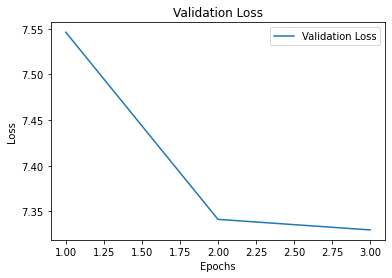

In [ ]:
from matplotlib.pylab import plt
from numpy import arange

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1,4)

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display the plot
plt.legend(loc='best')
plt.show()